In [1]:
import pandas as pd
import requests
import networkx as nx
import random
from collections import Counter
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns

In [2]:
url = "https://crowding.data.tfl.gov.uk/NUMBAT/NUMBAT%202023/NBT23FRI_outputs.xlsx"

r = requests.get(url)
with open("NBT23FRI_outputs.xlsx", "wb") as f:
    f.write(r.content)

xls = pd.ExcelFile("NBT23FRI_outputs.xlsx")
print(xls.sheet_names)

['_Cover', 'Link_Loads', 'Link_Frequencies', 'Line_Boarders', 'Station_Flows', 'Station_Entries', 'Station_Exits', 'Station_Boarders', 'Station_Alighters']


## Monte Carlo-Based Route Simulation

To capture realistic patterns of passenger movement within the transport network, we implemented a Monte Carlo simulation pipeline. A directed graph was first constructed from station-to-station flow data, where each edge was weighted by total passenger volume. Transfer behavior at interchange stations was modeled probabilistically, enabling random transitions between lines based on a predefined probability.
  
A total of 30,000 simulated routes were generated (with references supporting simulation size selection). Each route began at a station selected in proportion to its entry volume, and proceeded step by step, with each subsequent station drawn from a weighted distribution based on observed link flows. This stochastic approach captures both dominant travel behaviors and realistic variability in passenger routing.
  
The simulated dataset was then used to extract origin-destination (OD) pairs, calculate route frequencies, and identify consistently recurring patterns. OD pairs that occurred above a fixed threshold (e.g., ≥25 appearances, determined by analyzing the simulated frequency distribution) were retained for subsequent accessibility evaluation.

In [3]:
df_links = pd.read_excel(xls, sheet_name="Link_Loads", header=2)
df_flows = pd.read_excel(xls, sheet_name="Station_Flows", header=2)
df_entries = pd.read_excel(xls, sheet_name="Station_Entries", header=2)
df_exits = pd.read_excel(xls, sheet_name="Station_Exits", header=2)
df_boarders = pd.read_excel(xls, sheet_name="Station_Boarders", header=2)
df_alighters = pd.read_excel(xls, sheet_name="Station_Alighters", header=2)

# Extract a sorted list of interchange station names from flow data
def extract_interchange_stations(df_flows):
    interchange_rows = df_flows[df_flows["Movement"].str.contains("Interchange", na=False)]
    interchange_stations = sorted(interchange_rows["To Station"].dropna().unique())
    return interchange_stations

# Construct a directed graph where nodes are stations and edges represent flows
def build_graph_from_links(df_links, entry_stations=None, exit_stations=None):
    G = nx.DiGraph()
    for _, r in df_links.iterrows():
        # Add edge with weight = flow volume
        G.add_edge(r["From Station"], r["To Station"], weight=r["Total"])
    # Ensure all entry and exit stations are in the graph
    if len(entry_stations) > 0:
        for station in entry_stations:
            if station not in G:
                G.add_node(station)
    if len(exit_stations) > 0:
        for station in exit_stations:
            if station not in G:
                G.add_node(station)
    return G

def build_entry_weights(df_entries):
    entries = df_entries[["Station", "Total"]].dropna()
    return dict(zip(entries["Station"], entries["Total"]))

def build_exit_weights(df_exits):
    exits = df_exits[["Station", "Total"]].dropna()
    return dict(zip(exits["Station"], exits["Total"]))

# Create dictionaries for total boardings and alightings per station
def build_board_alight_dicts(df_boarders, df_alighters):
    board_dict = df_boarders.groupby("Station")["Total"].sum().to_dict()
    alight_dict = df_alighters.groupby("Station")["Total"].sum().to_dict()
    return board_dict, alight_dict

# Simulate a single route starting from a given station
# Incorporates random transfers at interchange stations and weighted moves based on flow
def simulate_route(G, start, interchange_list, board_dict, alight_dict,
                   max_steps=5, transfer_prob=0.3):
    path = [start]
    cur = start
    score = 0
    for _ in range(max_steps):
        # Possibly transfer at interchange stations based on probability
        if cur in interchange_list and random.random() < transfer_prob:
            candidates = [s for s in G.successors(cur) if s in interchange_list and s not in path]
            if candidates:
                nxt = random.choice(candidates)
                path.append(f"[TRANSFER→]{nxt}")
                cur = nxt
                continue

        if cur not in G:
            break
        succ = [s for s in G.successors(cur) if s not in path]
        if not succ:
            break
        # Choose next station based on link weights (passenger volume)
        weights = [G[cur][s]["weight"] for s in succ]
        cur = random.choices(succ, weights=weights, k=1)[0]
        path.append(cur)
        score += board_dict.get(cur, 0) + alight_dict.get(cur, 0)
    return path, score

# Run multiple route simulations and collect results
def run_simulation_pipeline(df_links, df_flows, df_entries, df_exits, df_boarders, df_alighters,
                            num_routes=10000):
    interchange_stations = extract_interchange_stations(df_flows)
    entry_stations = df_entries["Station"].dropna().unique()
    exit_stations = df_exits["Station"].dropna().unique()
    start_stations = df_entries.sort_values(by="Total", ascending=False)["Station"].tolist()
    end_stations = df_exits.sort_values(by="Total", ascending=False)["Station"].tolist()
    G = build_graph_from_links(df_links, entry_stations, exit_stations)
    entry_weights = build_entry_weights(df_entries)
    exit_weights = build_exit_weights(df_exits)
    board_dict, alight_dict = build_board_alight_dicts(df_boarders, df_alighters)

    starts = list(entry_weights.keys())
    weights = list(entry_weights.values())

    routes = []
    scores = []
    ends = []

    for _ in range(num_routes):
        start = random.choices(starts, weights=weights, k=1)[0]
        path, score = simulate_route(G, start, interchange_stations, board_dict, alight_dict)
        routes.append(path)
        scores.append(score)
        # Remove transfer tags to get clean end station
        clean_path = [step for step in path if not str(step).startswith("[TRANSFER")]
        end = clean_path[-1] if len(clean_path) >= 2 else None
        ends.append(end)

    df_result = pd.DataFrame({
        "Route": routes,
        "Score": scores,
        "End": ends
    })

    df_result["End Exit Volume"] = df_result["End"].map(exit_weights)

    df_result["Start"] = df_result["Route"].apply(lambda x: x[0] if len(x) > 0 else None)
    df_result["End Clean"] = df_result["End"]
    df_result = df_result[df_result["Start"].isin(start_stations) & df_result["End Clean"].isin(end_stations)]

    return df_result

def plot_route_pair_frequencies(df_result):
    # Create a combined Start-End key for each route
    df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End Clean"]

    # Count frequency of each unique Start-End pair
    pair_counts = df_result["Route_Pair"].value_counts().reset_index()
    pair_counts.columns = ["Route_Pair", "Count"]

    # Sort by frequency descending
    pair_counts = pair_counts.sort_values(by="Count", ascending=False).reset_index(drop=True)

    # Plot the frequencies as a line chart
    plt.figure(figsize=(14, 6))
    plt.plot(range(len(pair_counts)), pair_counts["Count"], marker='o', linewidth=1.5)
    plt.title("Frequency of Simulated Start-End Route Pairs", fontsize=14)
    plt.xlabel("Route Pair Rank (sorted by frequency)", fontsize=12)
    plt.ylabel("Number of Simulated Occurrences", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_cumulative_route_distribution(df_result, top_k_lines=[10, 50, 100]):
    df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End Clean"]
    pair_counts = df_result["Route_Pair"].value_counts()

    total = pair_counts.sum()
    cumulative = pair_counts.cumsum() / total

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(cumulative)+1), cumulative.values, marker='.', linewidth=2)
    plt.xlabel("Route Pair Rank (sorted by frequency)", fontsize=12)
    plt.ylabel("Cumulative Share of Simulated Routes", fontsize=12)
    plt.title("Cumulative Distribution of Start-End Route Pair Frequencies", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    for k in top_k_lines:
        if k <= len(cumulative):
            plt.axvline(k, color='gray', linestyle=':', alpha=0.7)
            plt.text(k, cumulative.values[k-1] + 0.02, f"Top {k}: {cumulative.values[k-1]*100:.1f}%", 
                     ha='right', fontsize=10, color='black')

    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

To capture the variability and distribution of possible travel routes in a realistic manner, we employed a Monte Carlo simulation approach. A total of 30,000 simulation runs were conducted. This number was selected as a balance between computational efficiency and statistical robustness.
  
According to the law of large numbers and the central limit theorem, the accuracy of Monte Carlo estimates improves at a rate of O(1/N^(1/2)), where N is the number of samples. In practical terms, increasing the number of runs from 10,000 to 30,000 reduces the expected standard error by approximately 42%, which significantly improves the stability of the estimated route frequency distribution without incurring excessive computational cost.
  
Furthermore, as discussed in Glasserman (2004) and Rubinstein & Kroese (2016), simulation sizes in the range of 10,000 to 100,000 are typically sufficient for modeling aggregate behaviors in large-scale stochastic systems, such as transportation networks. Therefore, we consider 30,000 simulations appropriate for capturing the dominant patterns in route choices and interchange behaviors within our data-driven model.
  
_References:_  
_Glasserman, P. (2003). Monte Carlo Methods in Financial Engineering. Springer_  
_Rubinstein, R. Y., & Kroese, D. P. (2016). Simulation and the Monte Carlo Method (3rd ed.). Wiley_

In [4]:
df_result = run_simulation_pipeline(
    df_links, df_flows, df_entries, df_exits,
    df_boarders, df_alighters,
    num_routes = 30000
    )

d:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

d:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



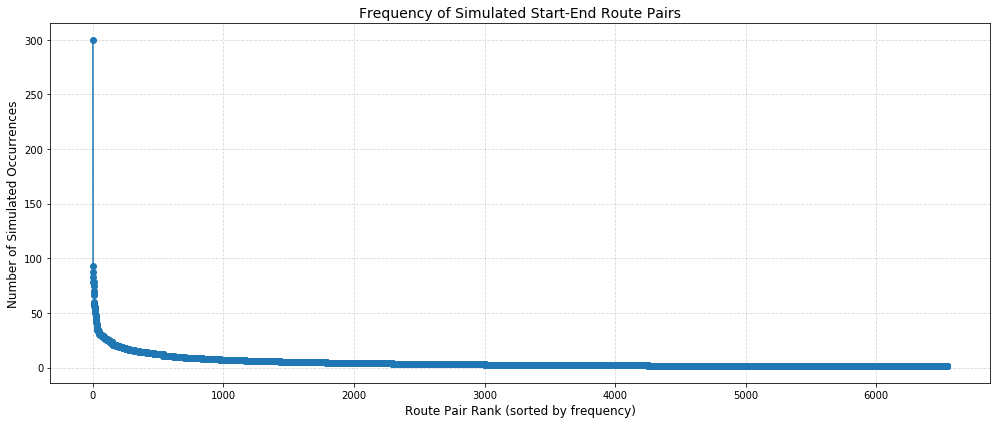

In [5]:
plot_route_pair_frequencies(df_result)

In order to identify the most representative and frequently used travel patterns from the Monte Carlo simulation, we define a route pair (start-end) as a popular route if it appeared 25 times or more among the 30,000 simulated journeys. This threshold was chosen based on the long-tailed distribution of route frequencies (see the figure above),  while a relatively small subset accumulates significantly higher counts.
  
By selecting a cutoff at 25 occurrences, we strike a balance between statistical significance and data coverage: the selected route pairs are not only sufficiently frequent to reflect recurring patterns, but also limited in number to allow focused downstream analysis. This approach helps avoid over-interpreting extremely rare, potentially random route combinations, and instead centers the analysis on routes that consistently emerge in the simulated travel behavior.

In [6]:
def count_frequent_route_pairs(df_result, min_occurrence=25):
    df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End Clean"]
    pair_counts = df_result["Route_Pair"].value_counts()
    frequent_pairs = pair_counts[pair_counts >= min_occurrence]
    print(f"Number of route pairs that occurred ≥ {min_occurrence} times: {len(frequent_pairs)}")
    return frequent_pairs

frequent_pairs = count_frequent_route_pairs(df_result, min_occurrence = 25)

Number of route pairs that occurred ≥ 25 times: 122


In [7]:
def save_frequent_route_pairs_split(df_result, min_occurrence = 25, filename = "frequent_routes.csv"):
    df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End Clean"]
    pair_counts = df_result["Route_Pair"].value_counts()

    frequent_pairs = pair_counts[pair_counts >= min_occurrence].reset_index()
    frequent_pairs.columns = ["Route_Pair", "Count"]
    frequent_pairs[["Start_Station", "End_Station"]] = frequent_pairs["Route_Pair"].str.split(" → ", expand=True)
  
    output_df = frequent_pairs[["Start_Station", "End_Station", "Count"]]
    output_df.to_csv(filename, index=False)
    
    print(f"Saved {len(output_df)} frequent route pairs to '{filename}'")
    return output_df

frequent_routes = save_frequent_route_pairs_split(df_result, min_occurrence = 25, filename = "frequent_routes_final.csv")

Saved 122 frequent route pairs to 'frequent_routes_final.csv'


**Note:** The dataset `frequent_routes_final.csv`, containing 122 frequent OD pairs, will be used in the subsequent stage to collect travel time data for both step-free accessible and regular routes.

## Bus Stop Optimization via P-Median Approximation

To identify optimal locations for additional bus stops, we formulated a simplified variant of the P-Median problem, with the objective of minimizing the total weighted walking cost across frequent OD (origin-destination) pairs derived from the simulated dataset. Each OD pair is weighted by its user count, and penalized by its walking time unless covered by one of the selected new facilities (i.e., bus stops).
  
OD pairs with walking times exceeding a minimum threshold were treated as "underserved". For each such pair, if either the origin or destination is selected as a new bus stop, we assume the walking burden is substantially reduced to a nominal value (set to 1 minute). Otherwise, the full walking cost (i.e., walk_time × user count) is retained. The algorithm evaluates all combinations of up to p new stop locations and selects the one that minimizes the total weighted cost.
  
For the purpose of verifying the method's functionality, both the maximum number of new stops (p = 3) and the minimum walking time threshold (walk_time ≥ 16) were selected arbitrarily. These values were not intended to reflect real-world planning assumptions and carry no empirical significance. They will be further calibrated or replaced based on empirical data and literature-informed benchmarks in subsequent analyses.
  
The method relies on an exhaustive combinatorial search and is therefore limited to a small number of candidate facilities. However, it provides an interpretable and data-driven framework for evaluating the potential impact of targeted interventions in improving network accessibility.

In [4]:
def suggest_new_bus_stops_from_od_walk(df_od, max_new_stops = 3, min_walk_threshold = 5):
    """
    Suggest new bus stops based on OD pairs with high walk_time.
    Expects df_od to contain: ['Start_Station', 'End_Station', 'Count', 'walk_time']
    """

    # Step 1: Filter OD pairs with long walk times
    df_long_walks = df_od[df_od["walk_time"] >= min_walk_threshold].copy()
    if df_long_walks.empty:
        print("No OD pairs exceed the minimum walk threshold.")
        return []

    # Step 2: Expand station frequency as potential demand
    candidate_nodes = set(df_long_walks["Start_Station"]).union(set(df_long_walks["End_Station"]))
    print(f"Found {len(df_long_walks)} OD pairs with walk_time ≥ {min_walk_threshold}")
    print(f"Candidate new stop locations: {len(candidate_nodes)} stations")

    # Step 3: Try all combinations of new stop placements (brute-force, only for small-scale)
    candidate_nodes = list(candidate_nodes)
    best_total_cost = float("inf")
    best_combo = None

    for combo in combinations(candidate_nodes, max_new_stops):
        total_cost = 0
        for _, row in df_long_walks.iterrows():
            u, v = row["Start_Station"], row["End_Station"]
            count = row["Count"]
            walk_time = row["walk_time"]

            # If this OD pair's start or end station is covered by a new bus stop,
            # we assume the walking burden is significantly reduced (e.g., to 1 minute).
            # Otherwise, we keep the original walk_time × number of users.
            if u in combo or v in combo:
                total_cost += 1 * count
            else:
                total_cost += walk_time * count

        if total_cost < best_total_cost:
            best_total_cost = total_cost
            best_combo = combo

    print(f"Suggested new bus stop locations (up to {max_new_stops}):")
    print(best_combo)
    print(f"Total weighted walk cost reduced to: {best_total_cost:.2f}")

    return best_combo

In [5]:
# Construct a directed graph where nodes are stations and edges represent flows
def build_graph_from_links(df_links, entry_stations=None, exit_stations=None):
    G = nx.DiGraph()
    for _, r in df_links.iterrows():
        # Add edge with weight = flow volume
        G.add_edge(r["From Station"], r["To Station"], weight=r["Total"])
    # Ensure all entry and exit stations are in the graph
    if len(entry_stations) > 0:
        for station in entry_stations:
            if station not in G:
                G.add_node(station)
    if len(exit_stations) > 0:
        for station in exit_stations:
            if station not in G:
                G.add_node(station)
    return G

**Note:**  
The dataset `frequent_routes_try.csv` was generated as a test set for experiments where walking time was used as the cost metric in the bus stop optimization.  The walking durations were created using randomized values and do not correspond to actual transport conditions.

As we decided not to proceed with the walking-time-based cost function in the final model, this dataset will no longer be provided or updated.  However, we chose to retain the corresponding code in the notebook for the sake of documenting all tested design alternatives in the final report and demonstrating the evolution of our modeling approach.

In [6]:
df_od = pd.read_csv("frequent_routes_try.csv")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)
suggest_new_bus_stops_from_od_walk(df_od, max_new_stops = 3, min_walk_threshold = 16)  # The numerical selection here is only to verify whether this code can run smoothly. Further changes will be made based on actual needs or literature support in the future.

Found 30 OD pairs with walk_time ≥ 16
Candidate new stop locations: 51 stations
Suggested new bus stop locations (up to 3):
("King's Cross St. Pancras", 'Edgware', 'Stockwell')
Total weighted walk cost reduced to: 12681.00


("King's Cross St. Pancras", 'Edgware', 'Stockwell')

We replaced the original walking-time-based cost with the total estimated travel time between each origin-destination pair, allowing for a more comprehensive reflection of real commuting burdens. For OD pairs whose origin or destination is covered by a new stop, the total time is reduced to a nominal value (e.g., 1 minute). All others retain their original total time. The optimization then selects the combination of up to p new stops that minimizes the weighted total commute time across all selected OD pairs.

Since the unified total travel time across OD pairs (rather than walking time alone) better captures user experience, we plan to use Google Maps API to obtain these values for the frequent OD pairs generated from simulation. A generic route-time estimation script is under development and being debugged. In the meantime, arbitrary values were used to test the algorithm pipeline.

In [5]:
def suggest_new_bus_stops_from_od_total(df_od, max_new_stops = 3, min_total_threshold = 15):
    """
    Suggest new bus stops based on OD pairs with high total travel time.
    Expects df_od to contain: ['Start_Station', 'End_Station', 'Count', 'total_time']
    """

    # Step 1: Filter OD pairs with long total travel time
    df_long_travel = df_od[df_od["Modified_time"] >= min_total_threshold].copy()
    if df_long_travel.empty:
        print("No OD pairs exceed the minimum total time threshold.")
        return []

    # Step 2: Identify candidate stations from underserved OD pairs
    candidate_nodes = set(df_long_travel["Start_Station"]).union(set(df_long_travel["End_Station"]))
    print(f"Found {len(df_long_travel)} OD pairs with total_time ≥ {min_total_threshold}")
    print(f"Candidate new stop locations: {len(candidate_nodes)} stations")

    # Step 3: Try all combinations of new stop placements (brute-force for small-scale test)
    candidate_nodes = list(candidate_nodes)
    best_total_cost = float("inf")
    best_combo = None

    for combo in combinations(candidate_nodes, max_new_stops):
        total_cost = 0
        for _, row in df_long_travel.iterrows():
            u, v = row["Start_Station"], row["End_Station"]
            count = row["Count"]
            total_time = row["Modified_time"]

            # If either end is covered by a new stop, we reduce total time to 1 minute
            if u in combo or v in combo:
                total_cost += 1 * count
            else:
                total_cost += total_time * count

        if total_cost < best_total_cost:
            best_total_cost = total_cost
            best_combo = combo

    print(f"Suggested new bus stop locations (up to {max_new_stops}):")
    print(best_combo)
    print(f"Total weighted travel cost reduced to: {best_total_cost:.2f}")

    return best_combo

**Note:**  
The dataset `final_complete_accessible_routes.csv` was generated using the Jupyter Notebook titled `FINAL_wheelchair_accessible__commute_time.ipynb`. This script implemented a web scraping pipeline simulating user interactions on Google Maps, retrieving step-free (wheelchair accessible) total travel times for OD pairs listed in `frequent_routes_final.csv`.

The scraping was necessary because Google Maps API does not support querying wheelchair-accessible options directly. The output of the notebook forms the basis for the final accessibility-based stop optimization.

In [ ]:
df_od = pd.read_csv("final_complete_accessible_routes.csv")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)
suggest_new_bus_stops_from_od_total(df_od, max_new_stops = 3, min_total_threshold = 30)

Found 66 OD pairs with total_time ≥ 30
Candidate new stop locations: 97 stations
Suggested new bus stop locations (up to 3):
('Seven Sisters', 'Wimbledon', 'Stratford')
Total weighted travel cost reduced to: 97355.00


('Seven Sisters', 'Wimbledon', 'Stratford')

### Analysis of Selected Bus Stop Candidates from Travel Time Distributions  

To further investigate why certain stations-Wimbledon, Stratford, and Seven Sisters-were repeatedly selected as optimal candidates for new bus stops in the model, we examined their step-free travel time distributions from both origin and destination perspectives.

#### As Start Stations  

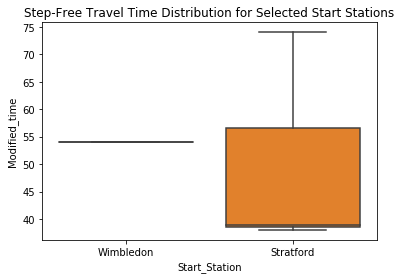

               count       mean        std   min   25%   50%   75%   max
Start_Station                                                           
Stratford        3.0  50.333333  20.502032  38.0  38.5  39.0  56.5  74.0
Wimbledon        1.0  54.000000        NaN  54.0  54.0  54.0  54.0  54.0


In [11]:
sns.boxplot(data=df_od[df_od["Start_Station"].isin(["Wimbledon", "Seven Sisters", "Stratford"])],
            x="Start_Station", y="Modified_time")
plt.title("Step-Free Travel Time Distribution for Selected Start Stations")
plt.show()

df_focus = df_od[df_od["Start_Station"].isin(["Wimbledon", "Seven Sisters", "Stratford"])]
print(df_focus.groupby("Start_Station")["Modified_time"].describe())

Boxplot analysis and descriptive statistics show that:
1. Stratford exhibits a relatively high mean step-free travel time (≈ 50 mins), with noticeable dispersion (std ≈ 20.5).
2. Wimbledon, though based on a single route, also shows a high travel time of 54 mins, suggesting limited accessibility.
3. Seven Sisters did not appear as a start station among high-burden OD pairs, indicating that its accessibility challenge may be more prominent when serving as a destination.

This suggests that Stratford and Wimbledon tend to be inefficient origin points under step-free routing, thus carrying higher weighted costs in the objective function.

#### As End Stations  

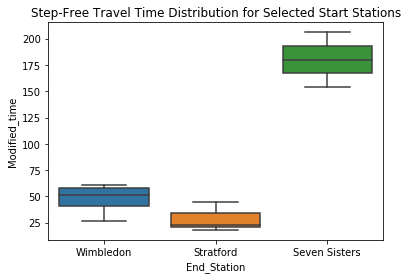

               count        mean        std    min    25%    50%    75%    max
End_Station                                                                   
Seven Sisters    2.0  180.000000  36.769553  154.0  167.0  180.0  193.0  206.0
Stratford        3.0   28.666667  14.364308   18.0   20.5   23.0   34.0   45.0
Wimbledon        4.0   47.500000  15.264338   27.0   40.5   51.0   58.0   61.0


In [ ]:
sns.boxplot(data=df_od[df_od["End_Station"].isin(["Wimbledon", "Seven Sisters", "Stratford"])],
            x="End_Station", y="Modified_time")
plt.title("Step-Free Travel Time Distribution for Selected Start Stations")
plt.show()

df_focus = df_od[df_od["End_Station"].isin(["Wimbledon", "Seven Sisters", "Stratford"])]
print(df_focus.groupby("End_Station")["Modified_time"].describe())

When switching to the destination perspective:
1. Seven Sisters shows exceptionally high step-free travel times, with a mean of 180 mins and a maximum exceeding 200 mins.
2. In contrast, Stratford and Wimbledon exhibit lower values as destination stations, indicating that their accessibility issues are more pronounced when they serve as origins rather than destinations.

This directional imbalance reveals that the burden of step-free travel is not symmetric.  The same station may be a greater bottleneck in one direction (e.g., Seven Sisters as a destination) than in the other.

### Filtering Long-Distance Outliers  

While directional imbalance has revealed stations like Seven Sisters to be disproportionately costly as destinations, further inspection uncovered that a small subset of OD pairs exhibited exceptionally long step-free travel times, in some cases exceeding 200 minutes. These extreme values-though real-risk skewing the optimization process by shifting attention toward a few distant stations at the expense of broader accessibility gains.

To mitigate this, we applied a 95th percentile threshold on total travel time (Modified_time) to trim the top 5% of excessively long OD pairs. This filtering step aimed to:

1. Avoid outlier-driven bias in subsequent stop placement suggestions.
2. Promote a more spatially balanced distribution of candidate locations.
3. Improve model interpretability by focusing on the majority user experience.

#### Statement about 95% Quantile for Travel Time Filtering

The longest 5% of routes (based on total modified travel time) were excluded to reduce the influence of extreme values. This choice is not dictated by a specific threshold in the literature, but follows a common practice in transport modeling to ensure robustness and eliminate outliers. Studies such as Geurs & van Wee (2004) and Papa & Bertolini (2015) have highlighted the distorting impact of rare long-distance journeys on accessibility metrics, and recommend percentile-based trimming as a defensible heuristic.

While the 95th percentile is not a universally "correct" cut-off, it strikes a pragmatic balance: removing the tail without excluding meaningful data.

_References:_  
_Geurs, K. T., & van Wee, B. (2004). Accessibility evaluation of land-use and transport strategies: Review and research directions. Journal of Transport Geography, 12(2), 127-140. https://doi.org/10.1016/j.jtrangeo.2003.10.005_  
_Papa, E., & Bertolini, L. (2015). Accessibility and transit-oriented development in European metropolitan areas. Journal of Transport Geography, 47, 70-83. https://doi.org/10.1016/j.jtrangeo.2015.07.003_

In [8]:
df_od = pd.read_csv("final_complete_accessible_routes.csv")
# 95% quantile threshold for Modified_time
threshold = df_od["Modified_time"].quantile(0.95)
df_od_trimmed = df_od[df_od["Modified_time"] <= threshold]
# Set max_new_stops to 3
suggest_new_bus_stops_from_od_total(df_od_trimmed, max_new_stops = 3, min_total_threshold = 30)

Found 60 OD pairs with total_time ≥ 30
Candidate new stop locations: 89 stations
Suggested new bus stop locations (up to 3):
('Clapham Common', 'Wimbledon', 'Colindale')
Total weighted travel cost reduced to: 79538.00


('Clapham Common', 'Wimbledon', 'Colindale')

#### Parameter Settings Justification

To ensure the tractability and interpretability of the optimization process, we initially set the maximum number of new bus stops to three. This value is not theoretically fixed but serves as **a practical baseline for sensitivity analysis**, in which we intend to evaluate how different constraint levels (e.g., allowing 2, 5, or more stops) impact overall accessibility improvements. This aligns with common practice in facility location problems, where budgetary or infrastructural limits are varied to assess cost–benefit trade-offs.

As for the minimum total travel time threshold, OD pairs with a regular journey duration shorter than 30 minutes were excluded. This filtering is guided by empirical conventions in urban transport research, where 30, 45, and 60 minutes are widely adopted as cut-off points to differentiate short, moderate, and long trips. These benchmarks are well established in datasets such as the London Travel Demand Survey (LTDS).

According to LTDS-a large-scale household travel diary survey conducted annually by Transport for London-commute durations are commonly categorized using thresholds like 30, 45, and 60 minutes (Travel in London 2023/2024; ITF, 2018). The use of a 30-minute threshold in this study is therefore consistent with recognized practice in accessibility and transport equity evaluations, allowing us to focus on journeys where time burdens are more pronounced and thus optimization interventions more impactful.

#### Sensitivity Analysis: Varying the Maximum Number of Additional Bus Stops

In [9]:
# Set max_new_stops to 2
suggest_new_bus_stops_from_od_total(df_od_trimmed, max_new_stops = 2, min_total_threshold = 30)

Found 60 OD pairs with total_time ≥ 30
Candidate new stop locations: 89 stations
Suggested new bus stop locations (up to 2):
('Wimbledon', 'Colindale')
Total weighted travel cost reduced to: 84903.00


('Wimbledon', 'Colindale')

In [ ]:
# Set max_new_stops to 4
suggest_new_bus_stops_from_od_total(df_od_trimmed, max_new_stops = 4, min_total_threshold = 30)

Found 60 OD pairs with total_time ≥ 30
Candidate new stop locations: 89 stations


In [10]:
# Set max_new_stops to 5
suggest_new_bus_stops_from_od_total(df_od_trimmed, max_new_stops = 5, min_total_threshold = 30)

Found 60 OD pairs with total_time ≥ 30
Candidate new stop locations: 89 stations


KeyboardInterrupt: 

**Note:**  
When setting max_new_stops = 5, the function failed to complete within a reasonable time limit (after running for nearly 58 hours). This suggests that the computational complexity of the optimization problem increases substantially with the number of candidate stop combinations.

To address this, we plan to revise the cost function used in the optimization process. Instead of using absolute travel time under step-free conditions, we will incorporate either:

1. The time difference between regular and step-free routes, or
2. The travel time ratio (e.g., regular travel time / step-free travel time)
as the cost metric to better capture accessibility gaps and reduce problem scale.